In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "models":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging
from pathlib import Path

import polars as pl

from src.data.database_manager import DatabaseManager
from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import prepare_data
from src.models.main import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_performance import (
    get_confusion_matrix,
    plot_confusion_matrix,
    plot_pr_curve,
    plot_roc_curve,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials

15:02:01 | INFO    | utils | Using device: mps
15:02:01 | INFO    | utils | Set seed to 42


polars.config.Config

In [3]:
model, features = load_model(
    "results/experiment_eda_phasic_eda_tonic_heartrate_pupil_mean/model/PatchTST_20250429-141311.pt",
    device="cpu",  # only for inference
)

15:02:01 | INFO    | utils | Loaded PatchTST model with test accuracy 0.77% to cpu.
15:02:01 | INFO    | utils | Input shape: (50, 4) | Features: ['eda_phasic', 'eda_tonic', 'heartrate', 'pupil_mean']


In [4]:
db = DatabaseManager()
with db:
    df = db.get_table("merged_and_labeled_data")

In [5]:
# Load data from database
db = DatabaseManager()
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )

# Prepare data
X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test = prepare_data(
    df, features, 5000, RANDOM_SEED
)

train_val_loader, test_loader = create_dataloaders(
    X_train_val, y_train_val, X_test, y_test, batch_size=64
)


15:02:02 | INFO    | data_preparation | Number of unique participants in training set: 24
15:02:02 | INFO    | data_preparation | Number of unique participants in validation set: 9
15:02:02 | INFO    | data_preparation | Number of unique participants in test set: 9
15:02:02 | DEBUG   | data_preparation | Participant IDs in test set: [ 7 11 17 24 30 33 36 37 48]
15:02:02 | DEBUG   | data_loader | Dataset summary: Train: 2220 samples, Test: 606 samples | Input shape: (2220, 50, 4), Label shape: (2220, 2)


Accuracy: 0.774


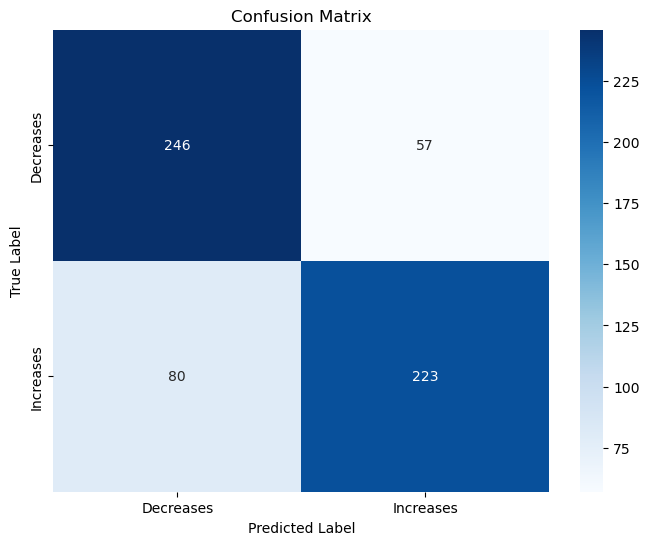

In [6]:
conf_matrix = get_confusion_matrix(model, test_loader, threshold=0.5)
plot_confusion_matrix(conf_matrix)


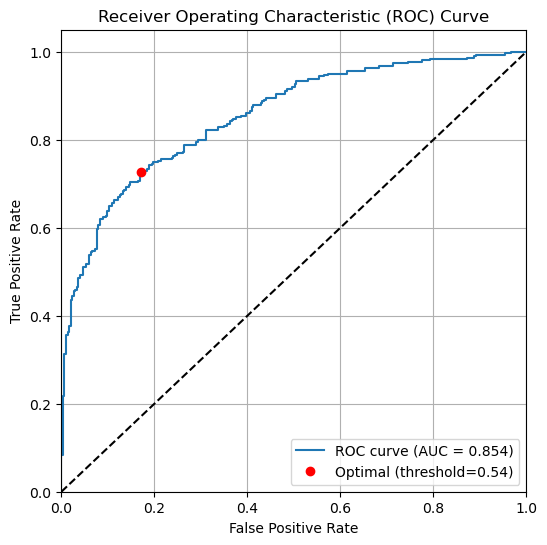

In [7]:
plot_roc_curve(model, test_loader)

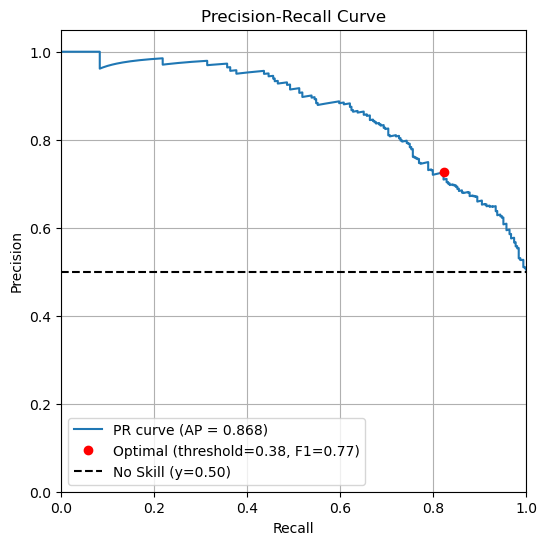

In [8]:
ap_score, optimal_pr_threshold = plot_pr_curve(model, test_loader)
# ap = average precision